<a href="https://colab.research.google.com/github/vorst4/temp_repos/blob/master/TUE_5LSM0_g6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

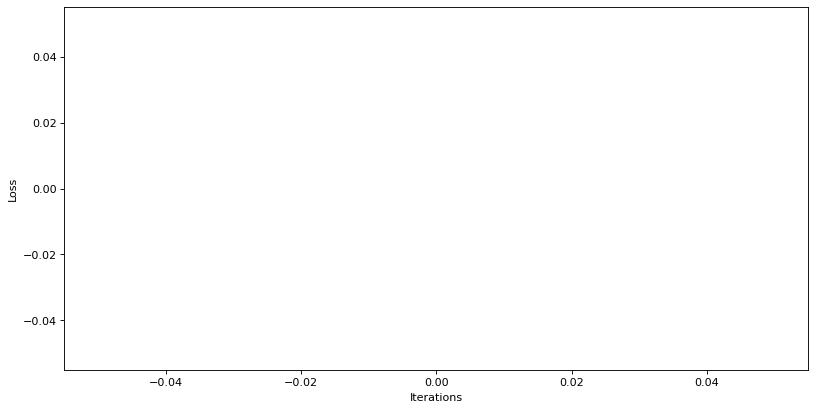

In [24]:
# ------------------------------ Import modules ------------------------------ #

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from google.colab import drive
from glob import glob
from datetime import datetime
from PIL import Image


# --------------------------- Functions & Classes ---------------------------- #

def download_reformat_and_organize(mnt_path='/content/drive', 
                                   token_path='/',
                                   desired_size = 512):
  """
  This function donwloads and organizes the data. More specifically:
  1.  Google Drive is mounted to colab.
  2.  Everything in the current folder that is related to the files that are to 
      be downloaded, or to the files that this function creates are DELETED.
      This is a precaution to prevent file conflicts.
  3.  Download the ISIC 2019 data from Kaggle. Your Kaggle token is needed for 
      this. To download your Kaggle token, visit https://www.kaggle.com , then 
      go to 'my account' and then 'download API token'. To pass your Kaggle
      token to the script, Google Drive is used. This way, multiple people can
      run/share the same script without sharing sensitive data. The token 
      should have the name 'kaggle.json' and be placed in Google Drive at the
      path specified by 'token_path'.
  3.  The downloaded data is unziped.
  4.  The widtha and height of the images are resized to 'desired_size' and 
      zero padding is added if necessary.
  4.  The train data/images are organized into subfolders. Each image is placed 
      into a subfolder that corresponds to its class. Doing this makes it
      possible to use 'torchvision.datasets.ImageFolder'.
  5.  The zip files and csv files are deleted since they are not needed anymore.
  6.  The test and training data is moved to Google Drive, to a folder with name
      '5LSM0-final-assignment'. Make sure that enough space is available, since 
      the function does not check this!

  Todo1:  link the metadata to the image, this is currently ignored.
  Todo2:  (low priority) replace command !mv that moves data to Google Drive 
          with python variant. Now the google drive path is hardcoded. This 
          means that mnt_path cannot be changed from the default.
  Todo3:  (low priority) add progress bar and/or 'time remaining' when 
          transforming the images, since this takes a while.
  
  Args:
    mnt_path (string): path where the google drive will be mounted.
    token_path (string): Path on Google Drive where the token can be found.
      With '/' being the root of Google Drive.
    desired_size (int): desired image width and height

  Returns:
    (none)
  """

  # make sure google drive is mounted
  print('\nMounting Google Drive...')
  drive.mount(mnt_path, force_remount=True)
  print('...Done')

  # remove files (in case this is a redownload)
  print('\nDeleting old files...')
  !rm -r ISIC_2019_Test_Input
  !rm -r ISIC_2019_Training_Input
  !rm -r isic-2019-training-input.zip
  !rm -r isic-2019-training-groundtruth.zip
  !rm -r isic-2019-test-input.zip
  !rm -r isic-2019-training-metadata.zip
  !rm -r isic-2019-test-metadata.zip
  !rm -r ISIC_2019_Training_GroundTruth.csv
  !rm -r ISIC_2019_Training_Metadata.csv
  !rm -r ISIC_2019_Test_Metadata.csv
  print('...Done')

  # Set kaggle configuration directory
  os.environ['KAGGLE_CONFIG_DIR'] = mnt_path+'/My Drive'+token_path

  # download data
  print('\nDownloading...')
  !kaggle datasets download -d kioriaanthony/isic-2019-training-input
  !kaggle datasets download -d kioriaanthony/isic-2019-training-groundtruth
  !kaggle datasets download -d kioriaanthony/isic-2019-test-input
  # !kaggle datasets download -d kioriaanthony/isic-2019-training-metadata
  # !kaggle datasets download -d kioriaanthony/isic-2019-test-metadata
  print('...Done')

  # unzip it (quietly)
  print('\nUnzipping...')
  !unzip -q isic-2019-training-input.zip
  !unzip -q isic-2019-training-groundtruth.zip
  !unzip -q isic-2019-test-input
  # !unzip -q isic-2019-test-metadata.zip
  # !unzip -q isic-2019-training-metadata.zip
  print('...Done')

  # resize and zero-padd images to desired size
  print('\nResizing and padding images...')
  for path in glob('/content/ISIC_2019_Test_Input/*.jpg') + \
              glob('/content/ISIC_2019_Training_Input/*.jpg'):
    # load image
    img = Image.open(path)
    # resize
    resized_size = np.array([img.width, img.height])*desired_size//max(img.size)
    img = img.resize(resized_size)
    # pad
    empty_img = Image.new("RGB", (desired_size, desired_size))
    paste_location = tuple((desired_size - resized_size)//2)
    empty_img.paste(img, paste_location)
    img = empty_img
    # save img
    img.save(path)
  print('...Done')

  # create subfolders with class name (if they do not exist yet) 
  print('\nCreating subdirs...')
  # path to training and test folder
  paths = ['/content/ISIC_2019_Training_Input/',
           '/content/ISIC_2019_Test_Input/']
  classes = ['mel', 'nv', 'bcc', 'ak', 'bkl', 'df', 'vasc', 'scc', 'unk']
  for path in paths:
    print('creating subdirs in: '+path)
    for clas in classes:
      if not os.path.exists(path+clas):
        os.mkdir(path+clas)
        print('created dir: '+clas)
      else:
        print('dir: '+clas+' already exists')
  print('...Done')

  # obtain the class that corresponds to each img and move it to its folder.
  print('\nReading classing and moving images')
  # Training data
  with open('ISIC_2019_Training_GroundTruth.csv', 'r') as f:
    next(f) # skip header (first line) of .csv file
    for line in f:
      # obtain image name and corresponding class name
      arr = np.array(line.split(','))
      img = arr[0]+'.jpg' # img name
      idx = np.where( arr[1:].astype(np.float) == 1.0 )[0][0] # class-index
      clas = classes[idx]
      # move image (if it exists)
      if os.path.exists(paths[0]+img):
        os.rename(paths[0]+img, paths[0]+clas+'/'+img) # rename = move
      else :
        print('img not found: '+img)
  # Test data (every class is unknown, so move everything to unk)
  for img in glob(paths[1]+'*.jpg'):
    name = img.split('/')[-1]
    os.rename(img, paths[1]+'unk/'+name)
  print('...Done')

  # remove zip & csv files 
  print('\nDeleting zip & csv files...')
  !rm -r isic-2019-training-input.zip
  !rm -r isic-2019-training-groundtruth.zip
  !rm -r isic-2019-test-input.zip
  !rm -r isic-2019-training-metadata.zip
  !rm -r isic-2019-test-metadata.zip
  !rm -r ISIC_2019_Training_GroundTruth.csv
  !rm -r ISIC_2019_Training_Metadata.csv
  !rm -r ISIC_2019_Test_Metadata.csv
  print('...Done')

  # move everything to drive
  print('\nMoving data to Google Drive...')
  !mv ISIC_2019_Test_Input 'drive/My Drive/5LSM0-final-assignment'
  !mv ISIC_2019_Training_Input 'drive/My Drive/5LSM0-final-assignment'
  print('...Done')


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

def init_colab():
  """
  Initializes colab by linking Google Drive to it, moving the training and 
  test data from the drive to the current workfolder and removing the default 
  'sample_data' folder since this is not used during this project. If the 
  test-data folder already exists in the current workfolder, the function 
  assumes colab is already initialized and it skips this.

  Args:
    (None)

  Returns:
    (None)
  """

  # prevent reinitialization by checking if test folder exists.
  if os.path.exists('ISIC_2019_Test_Input'):
    return

  # remove default sample_data folder, since it is unrelated to this project.
  !rm -r sample_data

  # mount google drive
  print('\nMounting Google Drive...')
  drive.mount('/content/drive')
  print('...Done')

  # copy test data from google drive to current folder
  print('\nCopying test folder from drive to workfolder...')
  !cp -ar 'drive/My Drive/5LSM0-final-assignment/ISIC_2019_Test_Input' /content/
  print('...Done')

  # copy training data from google drive to current folder
  print('\nCopying training folder from drive to workfolder...')
  !cp -ar 'drive/My Drive/5LSM0-final-assignment/ISIC_2019_Training_Input' /content/
  print('...Done')

# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

def dataloaders(root='/content/',
                train_img_dir='ISIC_2019_Training_Input/',
                test_img_dir='ISIC_2019_Test_Input/',
                batch_size=64,
                validation_size_percentage = 5):
  """
  This function creates and returns dataloaders for the train, validation and 
  test data set.

  Args:
    root (str): root directory
    train_img_dir (str): directory containing images of the training set
    test_img_dir (str): directory that contains the images of the test set
    batch_size (int): batch size
    validation_size_percentage (int, 0...100): the train data is split into train 
      and valuation. This percentage specifies how much of the original data is 
      used as validation. The remaining percentage will be the new train data.
  
  Returns: 
    train (torch.utils.data.DataLoader): object to load training data
    val (torch.utils.data.DataLoader): object to load validation data
    test (torch.utils.data.DataLoader): object to load test data
    N_train (int): number of training images
    N_val (int): number of validation images
    N_test (int): number of test images
  """

  # dataset transformation. Expand the dataset by adding random horzontal and 
  # vertical flips. 
  # todo: add more data transformations (but not to the test set ofcourse)
  # todo: the training image shapes are either 1024x1024 or 600x450. This is
  #       for the moment hotfixed by resizing it to 32x32. Note that, when 
  #       changing this, the neural net also needs to be changed
  # todo: data normalization
  transform_train = T.Compose([T.RandomHorizontalFlip(), 
                               T.RandomVerticalFlip(),
                               T.Resize((32,32)),  # todo: temporary fix
                               T.ToTensor()])
  transform_test  = T.ToTensor()

  # datasets
  dataset_train = dset.ImageFolder(root+train_img_dir, transform=transform_train)
  dataset_test = dset.ImageFolder(root+test_img_dir, transform=transform_test)

  # split train into validation and (new) train
  N = len(dataset_train.imgs)
  N_train = int(np.round(N*(100-validation_size_percentage)/100))
  N_val = N-N_train
  N_test = len(dataset_test.imgs)

  # samplers
  sampler_train = sampler.SubsetRandomSampler(range(N_train))
  sampler_val = sampler.SubsetRandomSampler(range(N_train, N))

  # dataloaders
  dl_train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_train)
  dl_val = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_val)
  dl_test = DataLoader(dataset_test, batch_size=batch_size)

  # add bool to see if certain dataset is the training dataset
  dl_train.dataset.train = True
  dl_val.dataset.train = True
  dl_test.dataset.train = False

  return dl_train, dl_val, dl_test, N_train, N_val, N_test


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

def train(model, optimizer, epochs=1, backup_after_epoch=True):
  """
  Trains the specified model and prints the progress
  
  Args:
    model (torch.nn.Module):  model
    optimizer (torch.optim.Optimizer): optimizer
    epochs (int): number of epochs to train the model

  Returns:
    (none)
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  model.loss = []
  model.acc_val = []
  model.acc_test = []
  model.elapsed_time = []
  time_start = time.clock()
      
  for e in range(epochs):
    for t, (x, y) in enumerate(dl_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=torch.long)
      scores = model(x)
      loss = F.cross_entropy(scores, y)
      
      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # backward pass, comput loss gradient
      loss.backward()

      # update parameters using gradients
      optimizer.step()
      
      # append loss 
      model.loss.append(loss)

      # update plot
      if t % print_every == 0:
        time_elapsed = time.strftime('%H:%M:%S', time.gmtime(time.clock()-time_start))
        stri = get_accuracy(dl_val, model)
        print('Iteration %d, loss = %.4f, time = %s, %s' % (t, loss.item(), time_elapsed, stri))
        

    my_lr_scheduler.step()
    model.elapsed_time = time.strftime('%H:%M:%S', time.gmtime(time.clock()-time_start))
    if backup_after_epoch:
      model.backup_to_drive()

    print(my_lr_scheduler.get_lr())


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

def get_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=torch.long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    if loader.dataset.train:
      model.acc_test.append(acc)
    else:
      model.acc_val.append(acc)
    return 'acc = %.2f, %d/%d correct' % (100 * acc, num_correct, num_samples)


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#



# -------------------------------- Neural Net -------------------------------- #

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

class ResNet(nn.Module):
  def __init__(self, block, num_classes=9):
    super(ResNet, self).__init__()
    self.backup_restore_name_prefix = 'resnet18_'
    self.backup_restore_path = '/content/drive/My Drive/5LSM0-final-assignment/'
    self.loss = []

    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, 
                            bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, stride=1)
    self.layer2 = self._make_layer(block, 128, stride=2)
    self.layer3 = self._make_layer(block, 256, stride=2)
    self.layer4 = self._make_layer(block, 512, stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, stride):
    strides = [stride,1] 
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

  def backup_to_drive(self):
    date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = self.backup_restore_path + self.backup_restore_name_prefix + date_time+'.pt'
    torch.save(model.state_dict(), path)

  def restore_from_drive(self, path):
    self.load_state_dict(torch.load(path))
    self.eval()

  def restore_latest(self):
    models = glob(self.backup_restore_path + self.backup_restore_name_prefix + '*.pt')
    try:
      self.restore_from_drive(models[-1])
    except:
      print('Error during restoring latest backup')
  
  def visualize(self):
    fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
    x = np.array(range(len(self.loss)))
    plt.plot(x, model.loss)
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.show()


    

# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

def ResNet18():
    return ResNet(BasicBlock)


# ------------------------------ Initialization ------------------------------ #

# initialize colab environment
init_colab()

# check if gpu/tpu is enabled
if torch.cuda.is_available() == False:
  raise ValueError('GPU/TPU not enabled. Goto runtime -> change runtime type')

# use gpu/tpu
device = torch.device('cuda')

# set variable type
dtype = torch.float32

# batch size, increase this until the RAM is full
batch_size = 128 # 128 -> ~200 iterations = 1 epoch

# create data loader objects for train, validation and test set. N_epoch is the
# number of images in 1 epoch
dl_train, dl_val, dl_test, N_epoch, N_val, N_test = dataloaders(batch_size=batch_size)

# when to print
print_every = 10


# ----------------------------------- Main ----------------------------------- #

# restore last backup of model?
load_backup = True

# learning rate (with decay)
# todo: make a script that runs the model with different rates
learning_rate = 1e-4
decayRate = 0.99

# model
model = ResNet18()

# load backup
if load_backup:
  model.restore_latest()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# learning rate
my_lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, 
                                                         gamma=decayRate)

# train
train(model, optimizer, epochs=10)

# visualize results
model.visualize()

# # save obtained model
# model.backup_to_drive()


# ----------------------------------- End ------------------------------------ #
